# NN reweighter example

In this notebook I want to give an example of a reweighter for multi-dimensional distributions

## 1. Prepare the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import pandas as pd

In [2]:
def getTree(filename, treename):
    file = ur.open(filename)
    tree = file[treename]
    array = tree.arrays(
        ['m_b', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum'], library='pd')
    return array

original = getTree('../data/MC_distribution.root', 'tree') #The original dataset to reweight
target = getTree('../data/RD_distribution.root', 'tree') # The target dataset


In [3]:
print(f'original.shape = {original.shape}')
print(f'target.shape   = {target.shape}')


original.shape = (1000000, 5)
target.shape   = (21441, 5)


We now need to arrange the data in a way that the NN can learn to how to reweight the original dataset into the target one. The standard `X`,`y` dataset configuration will be used. In this case, `y` will correspond to an integer (`0` or `1`) quantifying if an event correspond to the original (`y=1`) or target (`y=0`) dataset. The input array `X` is a vector with identical length of `y` including all the different variables to be accounted by the reweighting. 

In [5]:
X = pd.concat((original, target), ignore_index=True).values
y = []
for _df, ID in [(original, 1.), (target, 0.)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

In [6]:
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')


X.shape = (1021441, 5)
y.shape = (1021441,)


You can see that we have a total of `1021441` events with `5` variables to be considered by the reweighting. The next step is to shuffle randomly the events in `X` and `y` in order to avoid problems at the training stage of the NN.

In [7]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)


In [28]:
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (1021441, 5)
y.shape = (1021441,)


We are now almost ready to build and train our reweighting NN. We only have to normalize the variables in our data and also create a training and test dataset. Here we will keep 60% of events for training and 40% for test.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

ix = range(X.shape[0])
X_train, X_test, Y_train, Y_test, ix_train, ix_test = train_test_split(
    X, y, ix, train_size=0.6)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, X_test)
X_test = scaler.transform(X_test)

In [9]:
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')

X_train.shape = (612864, 5)
X_test.shape  = (408577, 5)


Congrats! The data are now ready and we can start to build our NN model. :)

## 2. Build the reweight NN model

In order to train our NN to reweight events with label `1` to `0` we need to build the Louppe loss function.

In [10]:
import keras.backend as K
def louppe_loss(y_true, y_pred):
    # The loss
    return (y_true * (K.sqrt(K.exp(y_pred))) +
            (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))


2023-09-27 15:43:45.745032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can now build the model. :)

In [11]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input

inputs = Input(shape=(X_train.shape[1], ))
hidden = Dense(20, activation='relu')(inputs)
hidden = Dense(20, activation='relu')(hidden)
hidden = Dense(20, activation='relu')(hidden)
outputs = Dense(1, activation='linear')(hidden)

model = Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


2023-09-27 15:44:03.623867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. Train the model

In [12]:
model.compile(loss=louppe_loss, metrics=['accuracy'], optimizer="adam")

In [13]:
history = model.fit(X_train, Y_train, epochs=20)

Epoch 1/20
19152/19152 [==============================] - 21s 1ms/step - loss: 0.1915 - accuracy: 0.0206
Epoch 2/20
19152/19152 [==============================] - 27s 1ms/step - loss: 0.1823 - accuracy: 0.0203
Epoch 3/20
19152/19152 [==============================] - 24s 1ms/step - loss: 0.1819 - accuracy: 0.0202
Epoch 4/20
19152/19152 [==============================] - 21s 1ms/step - loss: 0.1815 - accuracy: 0.0203
Epoch 5/20
19152/19152 [==============================] - 20s 1ms/step - loss: 0.1811 - accuracy: 0.0201
Epoch 6/20
19152/19152 [==============================] - 22s 1ms/step - loss: 0.1810 - accuracy: 0.0201
Epoch 7/20
19152/19152 [==============================] - 27s 1ms/step - loss: 0.1861 - accuracy: 0.0202
Epoch 8/20
19152/19152 [==============================] - 22s 1ms/step - loss: 0.1810 - accuracy: 0.0201
Epoch 9/20
19152/19152 [==============================] - 21s 1ms/step - loss: 0.1808 - accuracy: 0.0202
Epoch 10/20
19152/19152 [==============================

## 4. Make the prediction and plot the results

Now that the model is trained we are ready to predict our weights and apply them.

In [14]:
X_test_original, X_test_target = X_test[Y_test == 1], X_test[Y_test == 0]
yhat_orig = model.predict( X_test_original )

12500/12500 [==============================] - 11s 899us/step


We are almost there. These are not our weights directly, but the logs of them. :) Therefore, we can obtain the weights by simply exponentiating them.

In [17]:
weights = np.exp(yhat_orig)

Let's draw them

[]

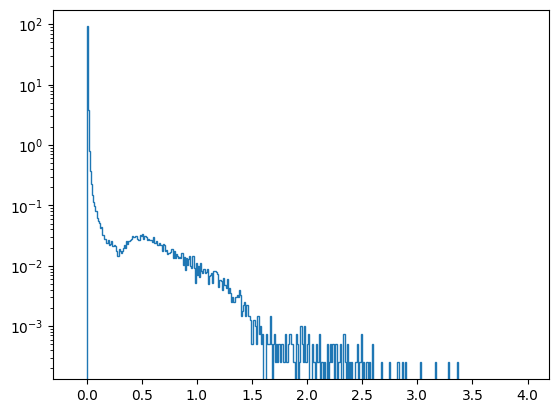

In [18]:
_ = plt.hist(weights, histtype='step',
             bins=np.arange(-0.1,4.0,0.01), label='original', density=True)
plt.semilogy()

It's now time to check if the NN reweighting worked. :)

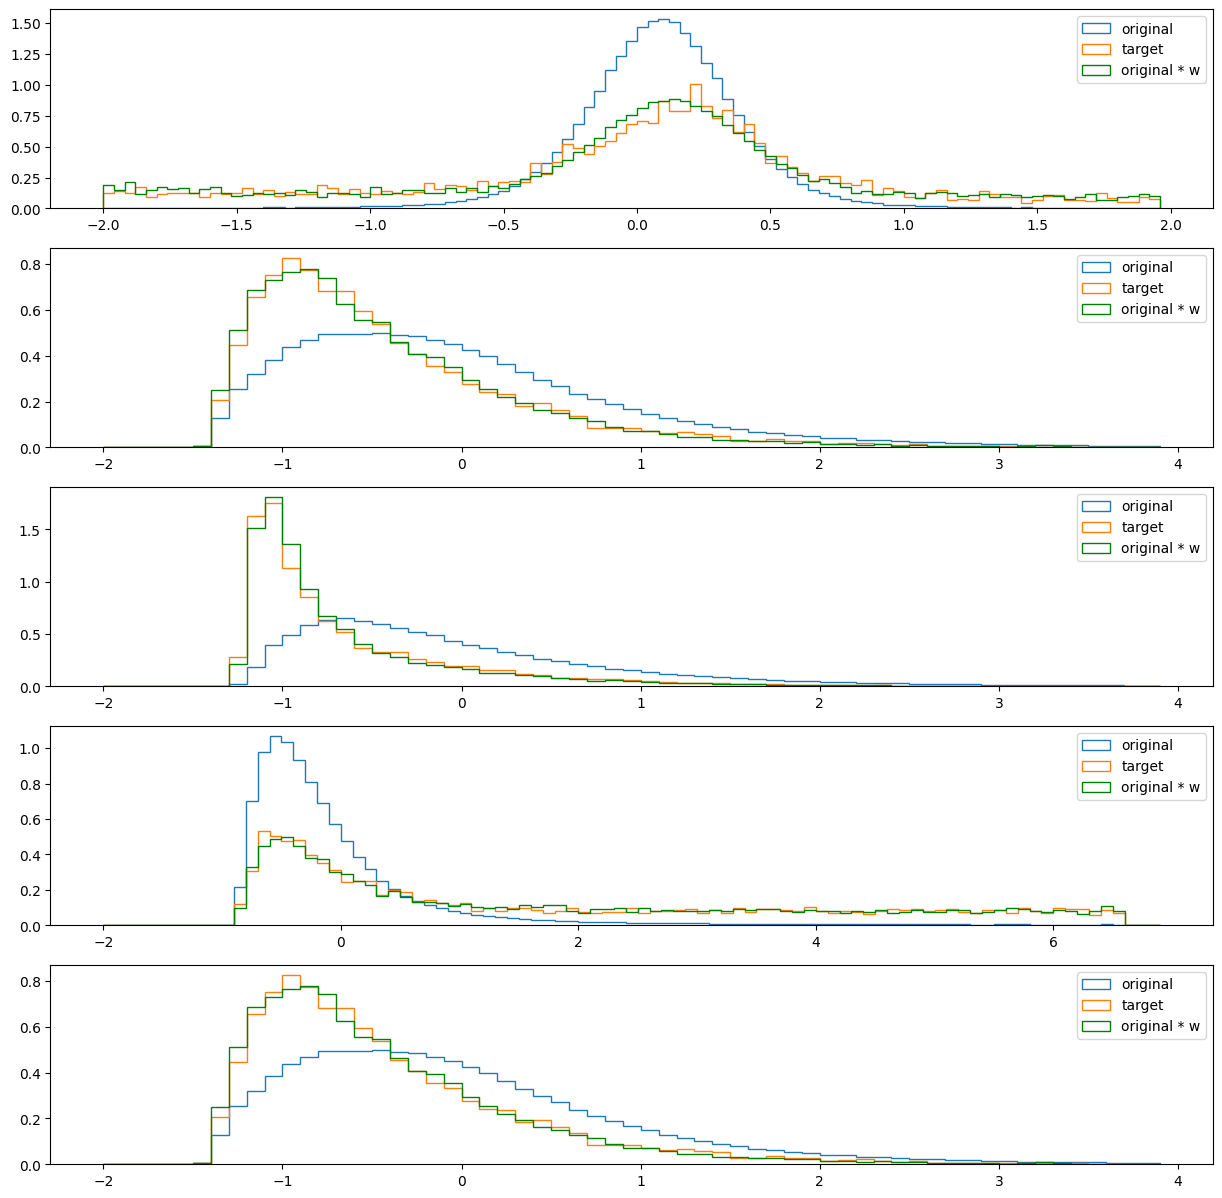

In [19]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax = plt.subplots(5,figsize=(15,15))
ranges = [np.arange(-2, 2, 0.04), np.arange(-2, 4, 0.1), np.arange(-2, 4, 0.1), np.arange(-2, 7, 0.1), np.arange(-2, 4, 0.1)]

for plot_index in range(5):
    _ = ax[plot_index].hist(X_test_original[:,plot_index], histtype='step',
                            bins=ranges[plot_index], label='original', density=True)
    _ = ax[plot_index].hist(X_test_target[:, plot_index], histtype='step',
                            bins=ranges[plot_index], label='target', density=True)
    _ = ax[plot_index].hist(X_test_original[:, plot_index], histtype='step',
                            bins=ranges[plot_index], label='original * w', density=True, color='g', weights=weights)
    ax[plot_index].legend(loc='best')
